# Experiments with the Time_Series_N2_SW_RW dataset

## Libraries

In [1]:
import sklearn
assert sklearn.__version__ >= "0.21", "Use the conda_python3_latest kernel!"

# Standard library
import os
import re
import warnings

# Third party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn import (dummy, linear_model, ensemble, 
                     metrics, preprocessing, pipeline, inspection, 
                     model_selection)

from IPython.display import display, Markdown

# Local
import utils

# matplotlib hackery
%matplotlib inline

## Load Dataset

In [2]:
df_orig = utils.load_dataset("s3://cpac/ORIG/Time_Series_N2_SW_RW/Time_Series_N2_SW_RW.csv")
df_orig.describe()

,M_Sub_Num,M_Trial_Num,T_tibia_force_N,T_tibia_force_BW,SW_vGRF_R_N,SW_vGRF_R_BW,SW_RFTangle_x,SW_RFTangle_y,SW_RFTangle_z,SW_RSKangle_x,...,RW_01_vGRF_R_N,RW_01_vGRF_R_BW,RW_02_RANKangle_x,RW_02_RANKangle_y,RW_02_RANKangle_z,RW_02_RKNangle_x,RW_02_RKNangle_y,RW_02_RKNangle_z,RW_01_COPx_R,RW_01_COPy_R
count,7979.000000,7979.000000,7979.000000,7979.000000,7979.000000,7979.000000,7979.000000,7979.000000,7979.000000,7979.000000,...,7979.000000,7979.000000,7979.000000,7979.000000,7979.000000,7979.000000,7979.000000,7979.000000,7979.000000,7979.000000
mean,2.518987,20.645570,2808.905917,4.153552,983.506309,1.449161,-10.598235,3.309441,-8.024490,-25.691223,...,672.772172,0.991410,12.477736,-1.761930,-3.358091,12.477736,-1.761930,-3.358091,40.590156,160.170606
std,0.499671,11.832942,1828.901662,2.705687,613.565840,0.894673,13.830319,5.083150,8.353102,15.040397,...,458.657573,0.670026,12.255673,7.861069,5.119614,12.255673,7.861069,5.119614,13.424777,61.130463
min,2.000000,1.000000,-20.104749,-0.031369,0.000000,0.000000,-50.412005,-6.197474,-23.205461,-47.313694,...,0.000000,0.000000,-29.602434,-26.413624,-15.125506,-29.602434,-26.413624,-15.125506,0.000000,0.000000
25%,2.000000,10.000000,1038.930508,1.546449,388.892360,0.578791,-17.314803,-0.014351,-15.667162,-37.555544,...,229.376286,0.338292,5.107531,-7.158920,-6.794084,5.107531,-7.158920,-6.794084,36.037025,148.352040
50%,3.000000,20.000000,2905.742338,4.324523,1070.434663,1.578598,-7.877453,2.784569,-11.223793,-32.120721,...,708.959689,1.055651,13.821571,0.222207,-4.039158,13.821571,0.222207,-4.039158,42.148500,180.971680
75%,3.000000,31.000000,4521.332183,6.646791,1509.599817,2.276731,-1.990479,5.801949,-0.007592,-14.677378,...,1071.144631,1.599717,22.633429,4.028849,-0.439652,22.633429,4.028849,-0.439652,49.838650,202.375820
max,3.000000,41.000000,6096.350566,8.848999,2117.944358,2.940364,29.365112,22.073129,8.701306,14.164457,...,1617.888940,2.246132,32.980503,11.113504,14.095430,32.980503,11.113504,14.095430,73.401160,232.654800


## Associate column names

In [3]:
def _get_columns_with_prefix(df, prefix):
    columns = []
    for column in df.columns:
        if column.startswith(prefix):
            columns.append(column)
    return columns
    
def get_target_names(df):
    return _get_columns_with_prefix(df, "T_")

def get_meta_names(df):
    return _get_columns_with_prefix(df, "M_")    

## Clean-up dataset

Nothing to do (for now).

In [4]:
df = df_orig.copy()
print(f"Number of samples: {df.shape[0]} (before clean-up: {df_orig.shape[0]})")
print(f"Number of types of trials: {len(df['M_Trial_Num'].unique())} (before clean-up: {len(df_orig['M_Trial_Num'].unique())})")
print(f"Number of executed trials: {len(df['M_Trial_Name'].unique())} (before clean-up: {len(df_orig['M_Trial_Name'].unique())})")
print(f"Number of subjects: {len(df['M_Sub_Num'].unique())}")

Number of samples: 7979 (before clean-up: 7979)
Number of types of trials: 41 (before clean-up: 41)
Number of executed trials: 79 (before clean-up: 79)
Number of subjects: 2


## Predictor configurations (recipes)

In [5]:
def predictor_short_name(predictor):
    return predictor[3:]

def predictor_sensor_number(predictor):
    sensor_numbers = {
        "SW_vGRF_R_N": "SW_01_00_00_00",
        "SW_vGRF_R_BW": "SW_01_00_00_00",
        "SW_RFTangle_x": "SW_07_08_00_00",
        "SW_RFTangle_y": "SW_07_08_00_00",
        "SW_RFTangle_z": "SW_07_08_00_00",
        "SW_RSKangle_x": "SW_06_07_00_00",
        "SW_RSKangle_y": "SW_06_07_00_00",
        "SW_RSKangle_z": "SW_06_07_00_00",
        "SW_COPx_R": "SW_01_02_00_00",
        "SW_COPy_R": "SW_01_02_00_00",
        
        "RW_01_vGRF_R_N": "RW_01_00_00_00", 
        "RW_01_vGRF_R_BW": "RW_01_00_00_00",
        "RW_02_RANKangle_x": "RW_07_08_00_00",
        "RW_02_RANKangle_y": "RW_07_08_00_00",
        "RW_02_RANKangle_z": "RW_07_08_00_00",
        "RW_02_RKNangle_x": "RW_06_07_00_00",
        "RW_02_RKNangle_y": "RW_06_07_00_00",
        "RW_02_RKNangle_z": "RW_06_07_00_00",
        "RW_01_COPx_R": "RW_01_02_00_00",
        "RW_01_COPy_R": "RW_01_02_00_00"
        
    }
    return sensor_numbers[predictor]

def filter_predictors(all_predictors, patterns):
    if isinstance(patterns, str):
        patterns = (patterns,)
        
    predictors = []
    for predictor in all_predictors:
        for pattern in patterns:
            if pattern in predictor:
                predictors.append(predictor)
                break
    return predictors


feature_sets = {
    "Recipe 1: Simulated Wearable - All Regular": 
        filter_predictors(df.columns, "SW_"),

    "Recipe 2: Real Wearable - All Regular": 
        filter_predictors(df.columns, "RW_"),
    
    "Recipe 3: Real Wearable - Insole Only":
        filter_predictors(
            filter_predictors(df.columns, "RW_"),
            ("GRF", "COP")
        ),
    
    "Recipe 4: Real Wearable - Insole + Ankle Angle Only":
        filter_predictors(
            filter_predictors(df.columns, "RW_"),
            ("GRF", "COP", "RANKangle")
        ),
    
}

for feature_set_name, predictors in feature_sets.items():
    sensors = set(map(predictor_sensor_number, predictors))
    print(f"{feature_set_name}\n\tPredictors: {len(predictors)}, Sensors: {len(sensors)}\n")
    print("\t" + "\n\t".join(predictors))
    print()

Recipe 1: Simulated Wearable - All Regular
	Predictors: 10, Sensors: 4

	SW_vGRF_R_N
	SW_vGRF_R_BW
	SW_RFTangle_x
	SW_RFTangle_y
	SW_RFTangle_z
	SW_RSKangle_x
	SW_RSKangle_y
	SW_RSKangle_z
	SW_COPx_R
	SW_COPy_R

Recipe 2: Real Wearable - All Regular
	Predictors: 10, Sensors: 4

	RW_01_vGRF_R_N
	RW_01_vGRF_R_BW
	RW_02_RANKangle_x
	RW_02_RANKangle_y
	RW_02_RANKangle_z
	RW_02_RKNangle_x
	RW_02_RKNangle_y
	RW_02_RKNangle_z
	RW_01_COPx_R
	RW_01_COPy_R

Recipe 3: Real Wearable - Insole Only
	Predictors: 4, Sensors: 2

	RW_01_vGRF_R_N
	RW_01_vGRF_R_BW
	RW_01_COPx_R
	RW_01_COPy_R

Recipe 4: Real Wearable - Insole + Ankle Angle Only
	Predictors: 7, Sensors: 3

	RW_01_vGRF_R_N
	RW_01_vGRF_R_BW
	RW_02_RANKangle_x
	RW_02_RANKangle_y
	RW_02_RANKangle_z
	RW_01_COPx_R
	RW_01_COPy_R



## Train/Test configurations

In [6]:
test_selectors = {
    "Subject 2 -> Subject 3": df["M_Sub_Num"] == 3,
    "Subject 3 -> Subject 2": df["M_Sub_Num"] == 2
}

train_test_sets = {}
for test_selector_name, test_selector in test_selectors.items():
    #df_train, df_test = df[~test_selector].dropna(), df[test_selector].dropna()
    df_train, df_test = df[~test_selector], df[test_selector]
    train_test_sets[test_selector_name] = (df_train, df_test)
    print(f"{test_selector_name}: {len(df_train)}/{len(df_test)} "
          f"({len(df_train) / len(df):.1%}/{len(df_test) / len(df):.1%})")

Subject 2 -> Subject 3: 3838/4141 (48.1%/51.9%)
Subject 3 -> Subject 2: 4141/3838 (51.9%/48.1%)


## Train and evaluate boosted tree models

In [7]:
def train_model(X_train, y_train):
    model = pipeline.Pipeline([
        ('scaler', preprocessing.StandardScaler()),
        ('gboost', ensemble.HistGradientBoostingRegressor())
    ]).fit(X_train, y_train)
    return model
    
def evaluate_model(desc, model, X_test, y_test, show_plot=False, show_importance=False):
    y_test_pred = model.predict(X_test)
    
    # Quantitative results
    rmse = np.sqrt(metrics.mean_squared_error(y_test_pred, y_test))
    r2 = metrics.r2_score(y_test_pred, y_test)
    
    display(
        Markdown(
            "---\n"
            f"**Target**: {desc['target']}  \n"
            f"**Features**: {desc['feature_set']}  \n"
            f"**Train/Test**: {desc['train_test_set']}  \n"
            f"**R2={r2:.3f}**"
        )
    )
    
    if show_plot:
        ax = sns.jointplot(y_test, y_test_pred, alpha=0.1, s=1.0, color=desc["color"])
        ax.set_axis_labels("Actual Tibia Force", 'Predicted Tibia Force', fontsize=14)
        ax.ax_joint.grid()
        ax.ax_marg_x.set_title("Predictions")

        summary = '\n'.join((
            r"$\mathrm{RMSE}=%.2f$" % (rmse,),
            r"$\mathrm{R}^2=%.3f$" % (r2,)
        ))

        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.ax_joint.text(0.05, 0.95, summary, transform=ax.ax_joint.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
        plt.show()
        
    if show_importance:
        feature_importances = inspection.permutation_importance(model, 
                                           X_test, 
                                           y_test, 
                                           n_repeats=5, n_jobs=-1)
        top_idxs = feature_importances.importances_mean.argsort()[::-1][:6]
        fig, ax = plt.subplots()
#         ax.boxplot(feature_importances.importances[top_idxs].T,
#                vert=False, labels=[predictor_short_name(X_test.columns[idx]) for idx in top_idxs])
        ax.barh(
            [predictor_short_name(X_test.columns[idx]) for idx in top_idxs], 
            feature_importances.importances_mean[top_idxs],
            color=desc["color"]
        )
        ax.set_title("Feature Importances")
        plt.show()
    
    return r2, pd.Series(y_test_pred, index=y_test.index)

def run_experiments(target_name, train_test_sets, color="steelblue"):
    warnings.filterwarnings('ignore')
    r2_scores = {}
    predictions = {}
    for train_test_set_name, (df_train, df_test) in train_test_sets.items():
        for feature_set_name, feature_names in feature_sets.items():
            desc = {"target": target_name, 
                    "feature_set": feature_set_name, 
                    "train_test_set": train_test_set_name,
                    "color": color
                   }
            model = train_model(df_train[feature_names], df_train[target_name])
            r2, prediction = evaluate_model(desc, model, df_test[feature_names], df_test[target_name], True, True)
            
            # title = f'{target_name} from "{feature_set_name}" on "{train_test_set_name}"'
            # print(f"{title}\n\tR2={r2:.3f}")
            
            r2_scores.setdefault(train_test_set_name, {})[feature_set_name] = r2
            predictions.setdefault(train_test_set_name, {})[feature_set_name] = prediction
    warnings.filterwarnings('default')
    return r2_scores, predictions


## Estimating T_tibia_force_N


---
**Target**: T_tibia_force_N  
**Features**: Recipe 1: Simulated Wearable - All Regular  
**Train/Test**: Subject 2 -> Subject 3  
**R2=0.962**

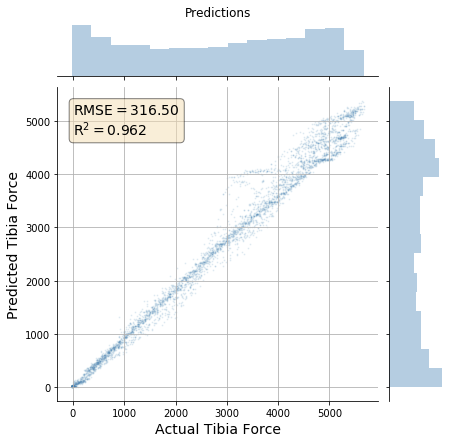

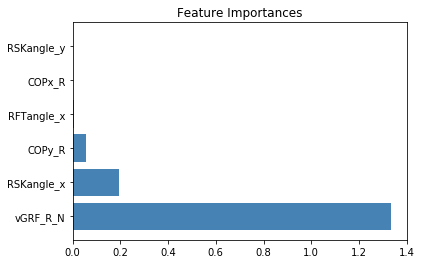

---
**Target**: T_tibia_force_N  
**Features**: Recipe 2: Real Wearable - All Regular  
**Train/Test**: Subject 2 -> Subject 3  
**R2=0.944**

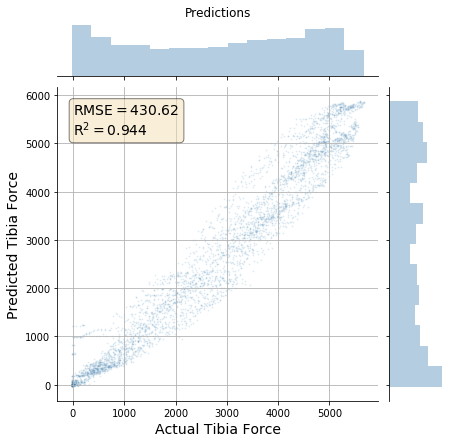

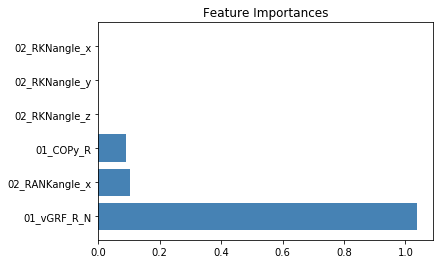

---
**Target**: T_tibia_force_N  
**Features**: Recipe 3: Real Wearable - Insole Only  
**Train/Test**: Subject 2 -> Subject 3  
**R2=0.944**

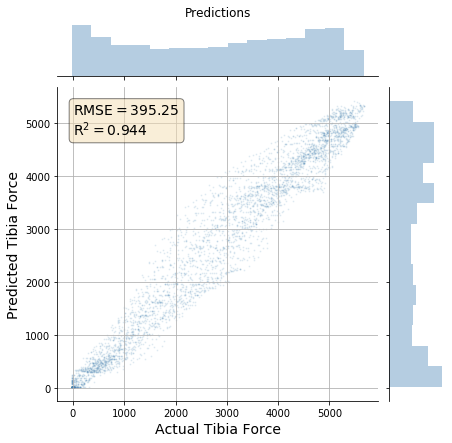

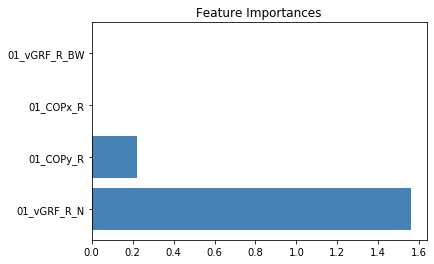

---
**Target**: T_tibia_force_N  
**Features**: Recipe 4: Real Wearable - Insole + Ankle Angle Only  
**Train/Test**: Subject 2 -> Subject 3  
**R2=0.944**

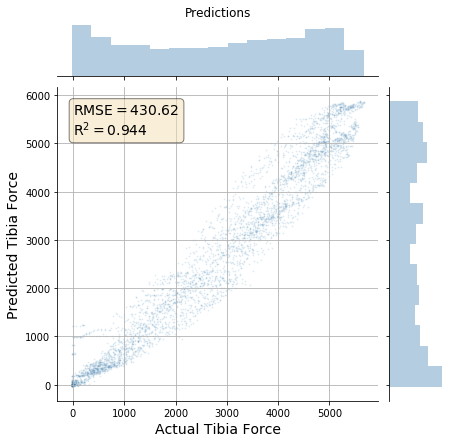

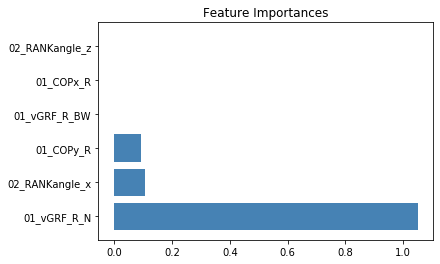

---
**Target**: T_tibia_force_N  
**Features**: Recipe 1: Simulated Wearable - All Regular  
**Train/Test**: Subject 3 -> Subject 2  
**R2=0.957**

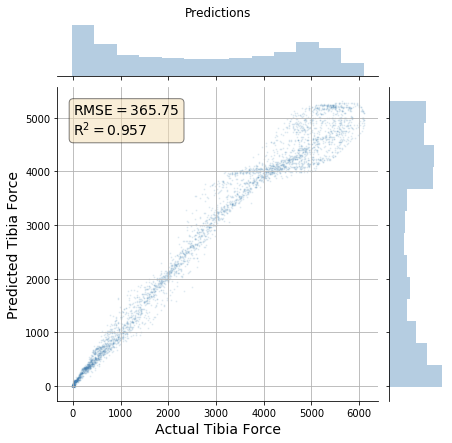

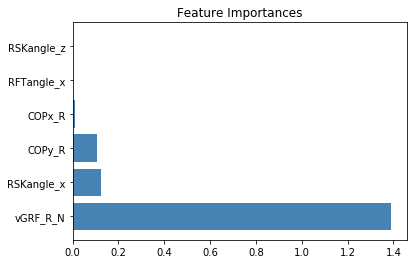

---
**Target**: T_tibia_force_N  
**Features**: Recipe 2: Real Wearable - All Regular  
**Train/Test**: Subject 3 -> Subject 2  
**R2=0.906**

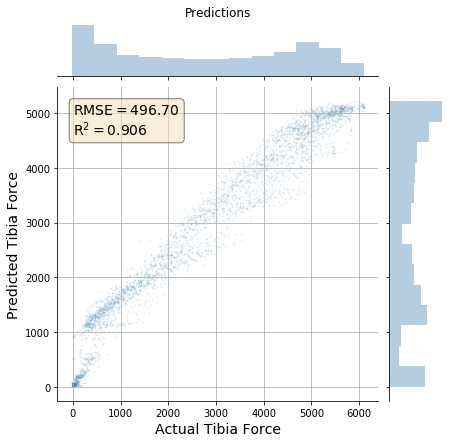

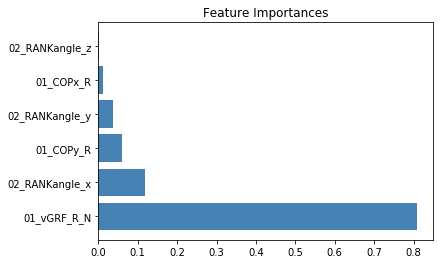

---
**Target**: T_tibia_force_N  
**Features**: Recipe 3: Real Wearable - Insole Only  
**Train/Test**: Subject 3 -> Subject 2  
**R2=0.931**

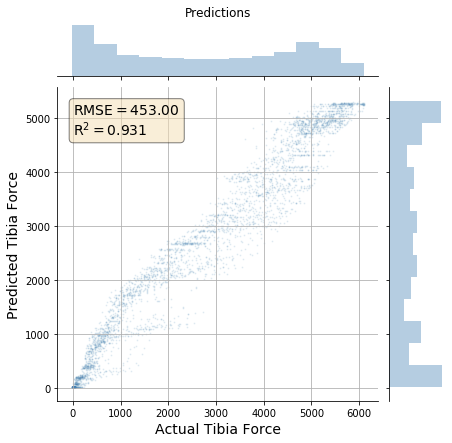

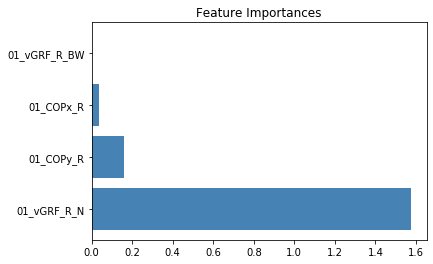

---
**Target**: T_tibia_force_N  
**Features**: Recipe 4: Real Wearable - Insole + Ankle Angle Only  
**Train/Test**: Subject 3 -> Subject 2  
**R2=0.906**

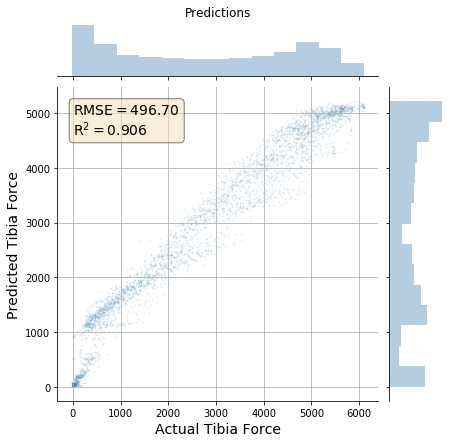

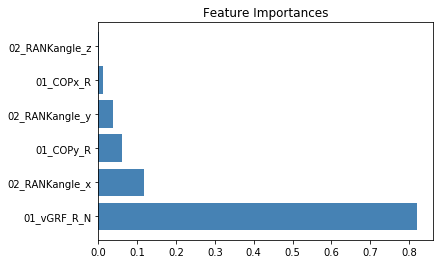

In [8]:
r2_scores_n, predictions_n = run_experiments("T_tibia_force_N", train_test_sets, color="steelblue")

## Estimating T_tibia_force_BW


---
**Target**: T_tibia_force_BW  
**Features**: Recipe 1: Simulated Wearable - All Regular  
**Train/Test**: Subject 2 -> Subject 3  
**R2=0.822**

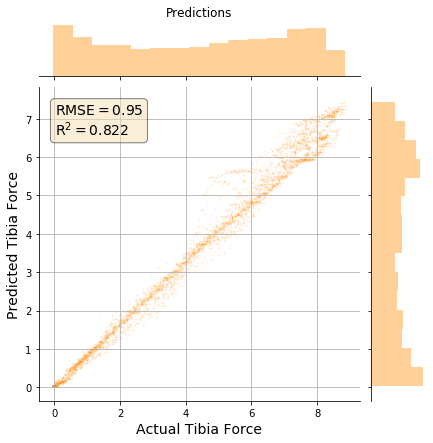

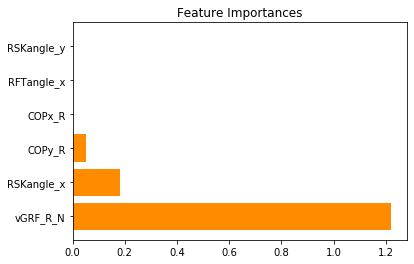

---
**Target**: T_tibia_force_BW  
**Features**: Recipe 2: Real Wearable - All Regular  
**Train/Test**: Subject 2 -> Subject 3  
**R2=0.881**

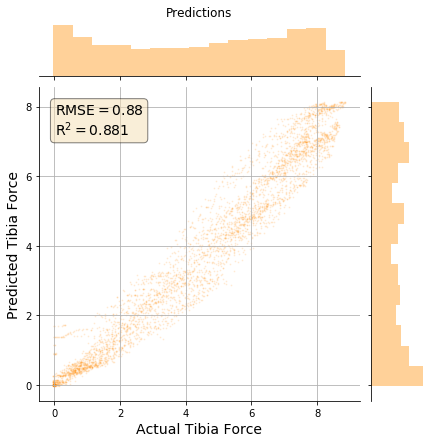

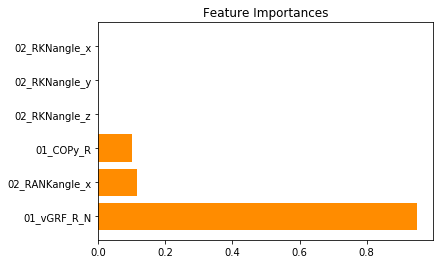

---
**Target**: T_tibia_force_BW  
**Features**: Recipe 3: Real Wearable - Insole Only  
**Train/Test**: Subject 2 -> Subject 3  
**R2=0.838**

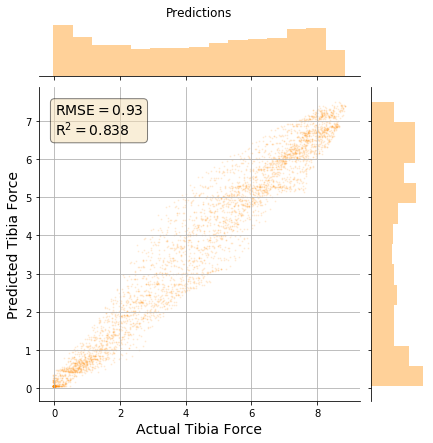

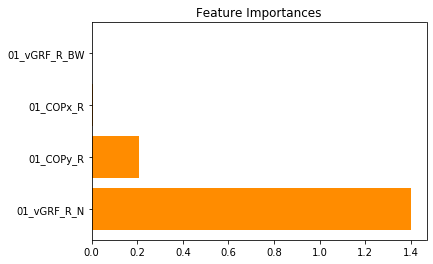

---
**Target**: T_tibia_force_BW  
**Features**: Recipe 4: Real Wearable - Insole + Ankle Angle Only  
**Train/Test**: Subject 2 -> Subject 3  
**R2=0.881**

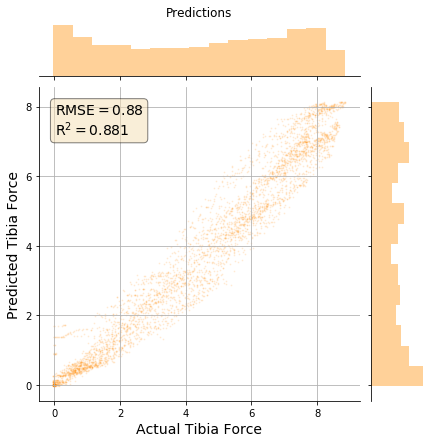

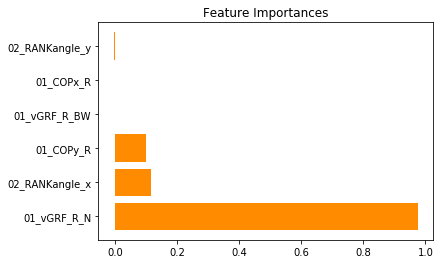

---
**Target**: T_tibia_force_BW  
**Features**: Recipe 1: Simulated Wearable - All Regular  
**Train/Test**: Subject 3 -> Subject 2  
**R2=0.956**

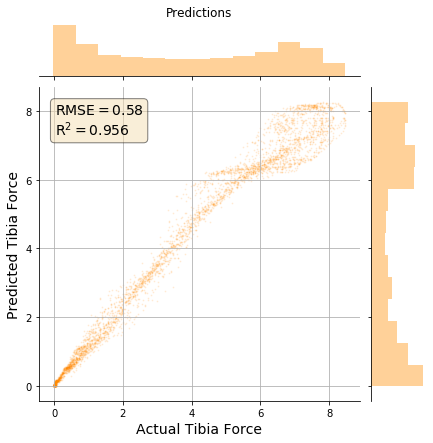

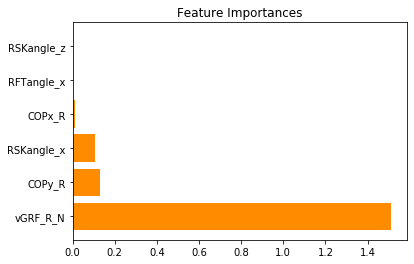

---
**Target**: T_tibia_force_BW  
**Features**: Recipe 2: Real Wearable - All Regular  
**Train/Test**: Subject 3 -> Subject 2  
**R2=0.883**

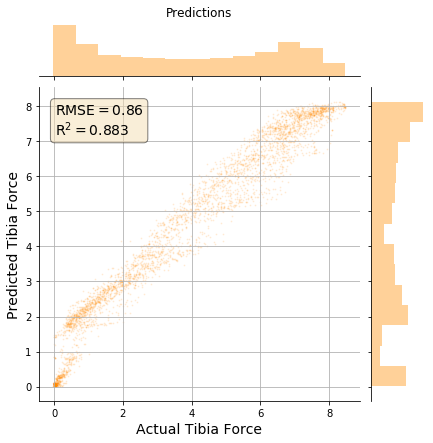

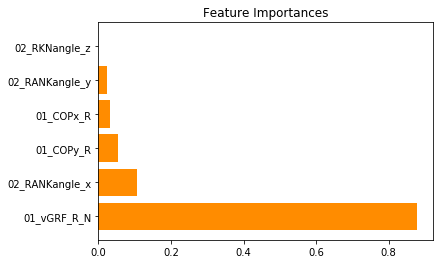

---
**Target**: T_tibia_force_BW  
**Features**: Recipe 3: Real Wearable - Insole Only  
**Train/Test**: Subject 3 -> Subject 2  
**R2=0.936**

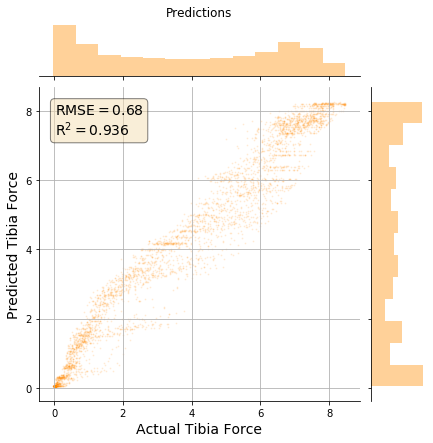

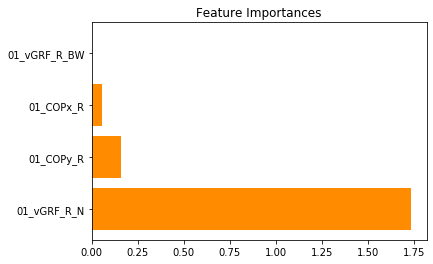

---
**Target**: T_tibia_force_BW  
**Features**: Recipe 4: Real Wearable - Insole + Ankle Angle Only  
**Train/Test**: Subject 3 -> Subject 2  
**R2=0.883**

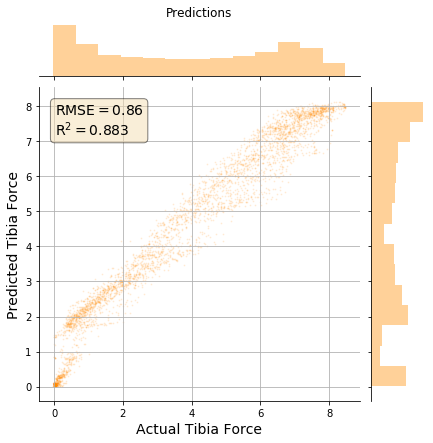

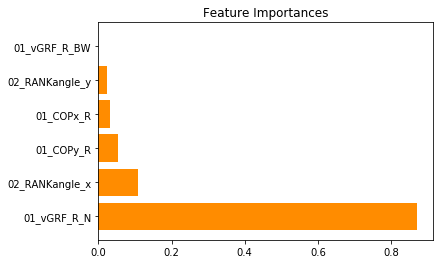

In [9]:
r2_scores_bw, predictions_bw = run_experiments("T_tibia_force_BW", train_test_sets, color="darkorange")

## Saving results

In [10]:
with pd.ExcelWriter('Time_Series_N2_SW_RW - Experiments.xlsx') as writer:
    pd.DataFrame(r2_scores_n).to_excel(writer, sheet_name='T_tibia_force_N')
    pd.DataFrame(r2_scores_bw).to_excel(writer, sheet_name='T_tibia_force_BW')

In [13]:
pred_df = df_orig.copy()

for feature_set in feature_sets:
    print(feature_set)
    merge_preds_n = predictions_n["Subject 2 -> Subject 3"][feature_set].append(
        predictions_n["Subject 3 -> Subject 2"][feature_set])
    merge_preds_bw = predictions_bw["Subject 2 -> Subject 3"][feature_set].append(
        predictions_bw["Subject 3 -> Subject 2"][feature_set])
    kwargs = {
        feature_set[:8] + "_T_tibia_force_N": merge_preds_n,
        feature_set[:8] + "_T_tibia_force_BW": merge_preds_bw,
             }
    pred_df = pred_df.assign(**kwargs)
pred_df.to_csv(f"Time_Series_N2_SW_RW - Predictions.csv")


Recipe 1: Simulated Wearable - All Regular
Recipe 2: Real Wearable - All Regular
Recipe 3: Real Wearable - Insole Only
Recipe 4: Real Wearable - Insole + Ankle Angle Only
